In [1]:

from importlib import reload
import os
import pandas as pd
from io import StringIO
import itertools
import ipdb
import datetime
from collections import Counter

import h5py
import json
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
print(tf.__version__)

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import mytf.s3utils as msu
import mytf.utils as mu
import mytf.plot as mp

1.14.0


Using TensorFlow backend.


In [2]:
tf.enable_eager_execution()

In [3]:
# train ... new datasets, ...
outdir = 'history/2019-12-22T174803Z'
train_loc = f'{outdir}/train_balanced.h5'
test_loc = f'{outdir}/test_balanced.h5'

print(mu.h5_keys(train_loc))
print(mu.h5_keys(test_loc))

['X_0', 'X_1', 'X_2', 'X_3', 'Ylabels_0', 'Ylabels_1', 'Ylabels_2', 'Ylabels_3']
['X_0', 'X_1', 'X_2', 'X_3', 'Ylabels_0', 'Ylabels_1', 'Ylabels_2', 'Ylabels_3']


In [4]:
# Grab and randomize since it's not huge...
vecs = [mu.read_h5_two(
                source_location=train_loc, 
                Xdataset=f'X_{i}',
                Ydataset=f'Ylabels_{i}')
                 for i in [0, 1, 2, 3]]

X_train = np.concatenate([x[0] for x in vecs])
Ylabels_train = np.concatenate([x[1] for x in vecs])

# Shuffle...
size = X_train.shape[0]
print(size)
indices = np.random.choice(range(size), size=size, replace=False)
X_train_shfl = X_train[indices]
Ylabels_train_shfl = Ylabels_train[indices].astype('int64')

X = X_train_shfl
Ylabels = Ylabels_train_shfl


34980


In [5]:
%%time 
# Train..

loss_history = []
validation_loss_history = []
save_dir = 'history'
BATCH_SIZE = 32
ts = mu.quickts(); print('starting,', ts)

size = X.shape[0]
workdir = f'{save_dir}/{ts}'
os.mkdir(workdir)
print(f'Made new workdir, {workdir}')
print('Ylabels, :', Counter(Ylabels))

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64,   dropout=0.2, recurrent_dropout=0.2,
                batch_input_shape=(None, 64, 8), 
              ),
    # 4 because 'A', 'B', 'C', 'D'.
    tf.keras.layers.Dense(4)])

class_weights = {0: 1., 1: 1., 2: 1., 3: 1.}
dataset_batches = mu.build_dataset_weighty_v3(
        {'x_train': X,
         'ylabels_train': Ylabels},
        list(range(size)), 
        class_weights,
        batch_size=BATCH_SIZE)
    
with ipdb.launch_ipdb_on_exception():
    mu.do_train(
        model,
        dataset_batches,
        k=size,
        saveloc=workdir)
    
    

starting, 2019-12-22T234352Z
Made new workdir, history/2019-12-22T234352Z
Ylabels, : Counter({0: 10230, 3: 8839, 2: 8286, 1: 7625})
num slices 1093
size_remainder,  4


/home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py:185: RuntimeWarning: divide by zero encountered in true_divide
  )/class_counts
W1222 23:43:53.064705 139892131759936 deprecation_wrapper.py:119] From /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py:238: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

0it [00:00, ?it/s]W1222 23:43:53.500033 139892131759936 deprecation_wrapper.py:119] From /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py:246: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.

W1222 23:43:53.516241 139892131759936 deprecation.py:323] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future v

CPU times: user 7min 43s, sys: 883 ms, total: 7min 44s
Wall time: 7min 44s


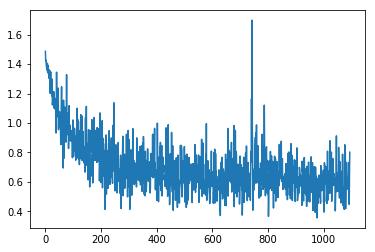

In [6]:
# history/2019-12-22T234352Z/00455_train_loss_history.json
#01068_train_loss_history.json
historydir = 'history'
with open(f'{historydir}/{ts}/01093_train_loss_history.json') as fd:
    losshistory = json.load(fd)
    
plt.plot(losshistory) 

In [8]:
# And just to get some quick results I can look at test loss, 
# for just one or two models.. maybe like 25% perhaps.
reload(mu)
import mytf.validation as mv

In [9]:
ts

'2019-12-22T234352Z'

In [ ]:
%%time

batch_losses_vec = []
#sess = tf.Session()
#with sess.as_default():
for step in tqdm(np.arange(0, 1094, 10)):
    #print(step)
    modelname = f'history/{ts}/{str(step).zfill(5)}_model.h5'
    #print(modelname)
    steploss = mv.perf_wrapper(modelname,
                               dataloc=test_loc,
                               eager=True)
    #print('steploss, ', steploss)
    batch_losses_vec.append([float(x) for x in steploss])
    mv.json_save({'batch_losses_vec': batch_losses_vec,
                  'step': int(step)
              }, 
              f'history/{ts}/{str(step).zfill(5)}_validation_losses.json')


  0%|          | 0/110 [00:00<?, ?it/s]W1223 00:20:03.461598 139892131759936 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.

  1%|          | 1/110 [02:12<4:01:22, 132.86s/it]W1223 00:22:16.242340 139892131759936 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.

  2%|▏         | 2/110 [04:25<3:59:00, 132.78s/it]W1223 00:24:28.833395 139892131759936 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.

  3%|▎         | 3/110 [06:38<3:56:49, 132.80s/it]W1223 00:26:41.550740 139892131759936 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.

  4%|▎         | 4/110 [08:52<3:55:10, 133.12s/it]W1223 00:28:55.412047 139892131759936 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Co

In [19]:
len(batch_losses_vec)

110

In [ ]:
# ^^ started at 2019-12-23T00:14:40UTC
# (false start)
#  new start 2019-12-23T00:20:03 ..
#
# also what does this mean ? .. is that why this is so slow?
# No training configuration found in save file: the model was *not* compiled. 
#        Compile it manually.

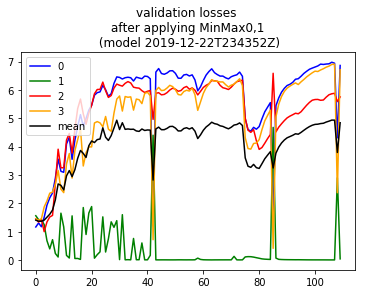

In [20]:
# .... hopefully if some of that stuff finishes ..
# I can run this ... 
lossesarr = np.array(batch_losses_vec)
meanlossesarr = np.mean(lossesarr, axis=1)

batch_losses_vec[:5]
#batch_losses_vec = []
#for step in np.arange(0, 1068, 10):
# [2.8359528, 0.45356295, 1.7049086, 4.099845]

plt.plot([x[0] for x in batch_losses_vec], color='blue', label='0')
plt.plot([x[1] for x in batch_losses_vec], color='green', label='1')
plt.plot([x[2] for x in batch_losses_vec], color='red', label='2')
plt.plot([x[3] for x in batch_losses_vec], color='orange', label='3')
plt.plot(meanlossesarr, color='black', label='mean')
plt.title(f'validation losses \n after applying MinMax0,1 \n (model {ts})')
plt.legend()
#plt.plot
